In [1]:
import numpy as np
import pylab as pl

In [2]:
from run_celerite_3term_jitter import *
from faraday_stuff import *

In [3]:
pl.rcParams['figure.figsize'] = [10, 5]
pl.rcParams['figure.dpi'] = 300

In [4]:
noise = 1.0  # noise per channel

In [5]:
indir = "./rfi_flagged/minus20-thin"
nu20, l2_20, stokesQ20, stokesU20 = read_data(indir, "training.txt")
stokesQ20n = stokesQ20 + np.random.normal(loc =0.0, scale=noise, size = len(stokesQ20))
stokesU20n = stokesU20 + np.random.normal(loc =0.0, scale=noise, size = len(stokesQ20))

In [6]:
indir = "./rfi_flagged/minus30-thin"
nu30, l2_30, stokesQ30, stokesU30 = read_data(indir, "training.txt")
stokesQ30n = stokesQ30 + np.random.normal(loc =0.0, scale=noise, size = len(stokesQ30))
stokesU30n = stokesU30 + np.random.normal(loc =0.0, scale=noise, size = len(stokesQ30))

In [7]:
indir = "./rfi_flagged/minus40-thin"
nu40, l2_40, stokesQ40, stokesU40 = read_data(indir, "training.txt")
stokesQ40n = stokesQ40 + np.random.normal(loc =0.0, scale=noise, size = len(stokesQ40))
stokesU40n = stokesU40 + np.random.normal(loc =0.0, scale=noise, size = len(stokesQ40))

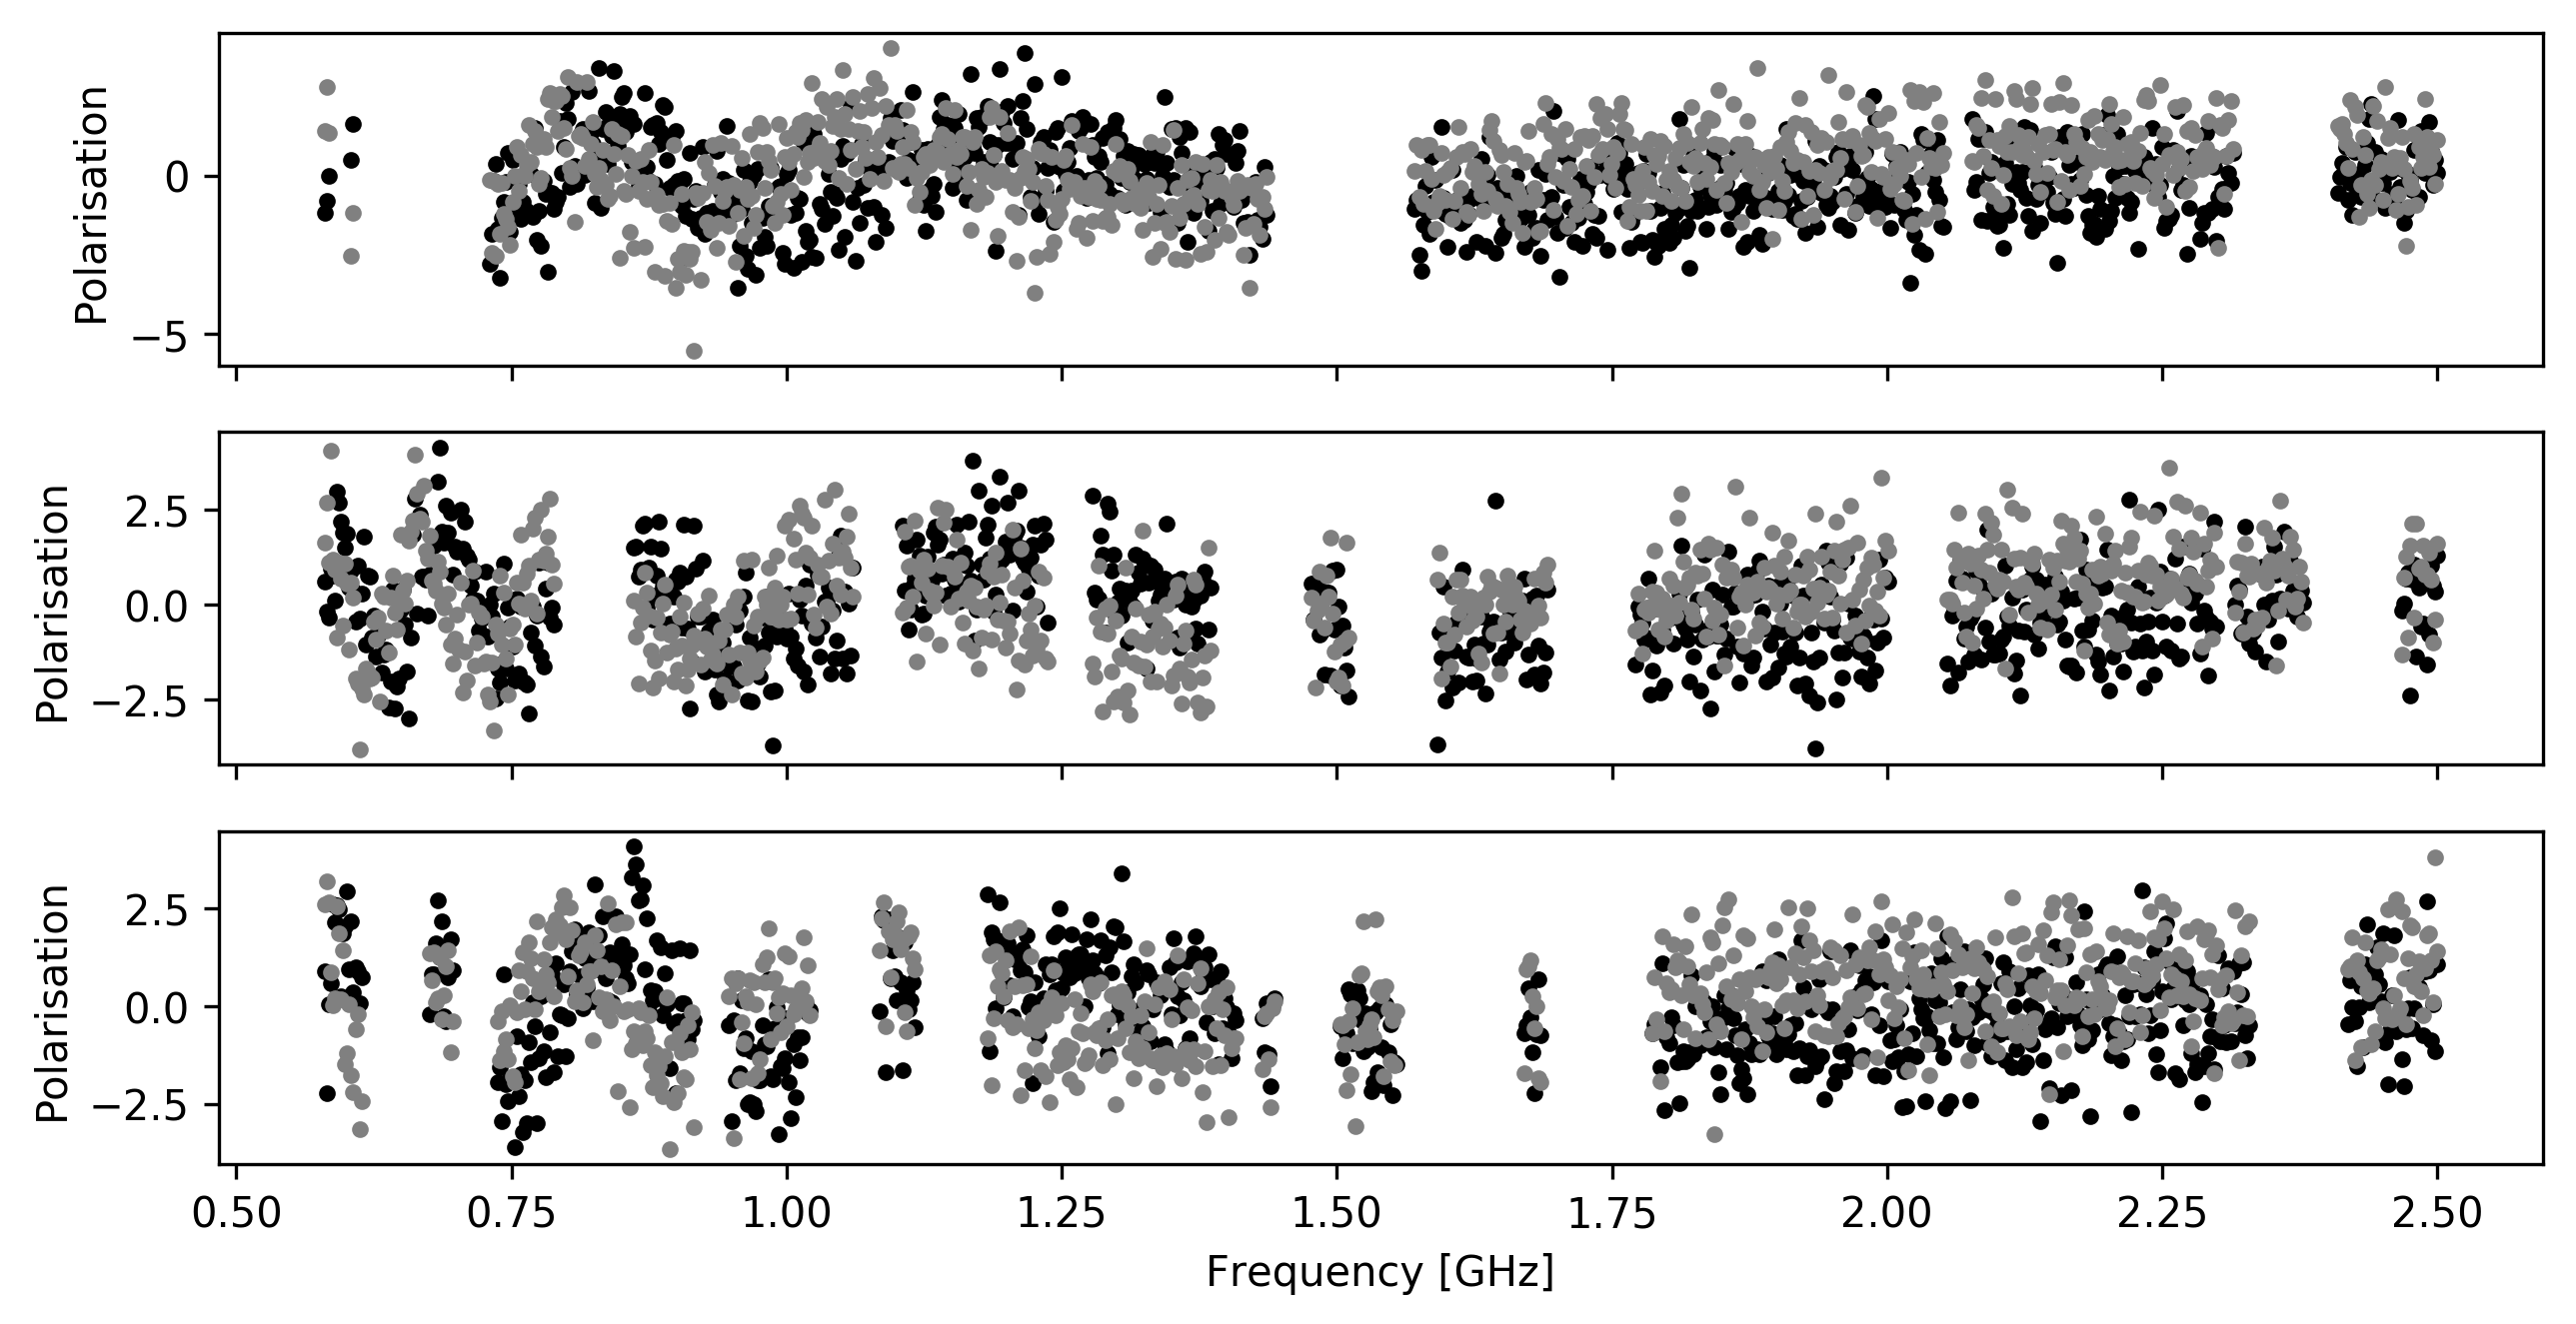

In [8]:
ax1 = pl.subplot(311)

ax1.errorbar(nu20/1e9, stokesQ20n, yerr=0., fmt='.', c='black', capthick=0, label="Stokes Q")
ax1.errorbar(nu20/1e9, stokesU20n, yerr=0., fmt='.', c='grey', capthick=0, label="Stokes U")

ax1.set_ylabel("Polarisation")
ax1.tick_params(labelbottom=False)    

ax2 = pl.subplot(312)

ax2.errorbar(nu30/1e9, stokesQ30n, yerr=0., fmt='.', c='black', capthick=0, label="Stokes Q")
ax2.errorbar(nu30/1e9, stokesU30n, yerr=0., fmt='.', c='grey', capthick=0, label="Stokes U")

ax2.set_ylabel("Polarisation")
ax2.tick_params(labelbottom=False)    

ax3 = pl.subplot(313)

ax3.errorbar(nu40/1e9, stokesQ40n, yerr=0., fmt='.', c='black', capthick=0, label="Stokes Q")
ax3.errorbar(nu40/1e9, stokesU40n, yerr=0., fmt='.', c='grey', capthick=0, label="Stokes U")

ax3.set_ylabel("Polarisation")
ax3.set_xlabel("Frequency [GHz]")

pl.show()

In [9]:
lstar = np.linspace(np.min(l2_20), np.max(l2_20), 512)

In [10]:
mu_q20, std_q20, mu_u20, std_u20 = celeriteoptimize_predict(l2_20, stokesQ20n, stokesU20n, lstar)

In [11]:
mu_q30, std_q30, mu_u30, std_u30 = celeriteoptimize_predict(l2_30, stokesQ30n, stokesU30n, lstar)

In [12]:
mu_q40, std_q40, mu_u40, std_u40 = celeriteoptimize_predict(l2_40, stokesQ40n, stokesU40n, lstar)

In [13]:
fspec20 = []; rmtf20 = []
fspec30 = []; rmtf30 = []
fspec40 = []; rmtf40 = []

w20 = np.ones(len(stokesQ20))
w30 = np.ones(len(stokesQ30))
w40 = np.ones(len(stokesQ40))

phi = np.linspace(-500,500,10000)

for i in range(0,len(phi)):
    fspec20.append(calc_f(phi[i],l2_20[::-1],stokesQ20n[::-1],stokesU20n[::-1],w20))
    rmtf20.append(calc_r(phi[i],l2_20[::-1],w20))
    fspec30.append(calc_f(phi[i],l2_30[::-1],stokesQ30n[::-1],stokesU30n[::-1],w30))
    rmtf30.append(calc_r(phi[i],l2_30[::-1],w30))
    fspec40.append(calc_f(phi[i],l2_40[::-1],stokesQ40n[::-1],stokesU40n[::-1],w40))
    rmtf40.append(calc_r(phi[i],l2_40[::-1],w40))
    
fspec20 = np.array(fspec20)
rmtf20 = np.array(rmtf20)
fspec30 = np.array(fspec30)
rmtf30 = np.array(rmtf30)
fspec40 = np.array(fspec40)
rmtf40 = np.array(rmtf40)

In [14]:
fspec20gp = []; rmtf20gp = []
fspec30gp = []; rmtf30gp = []
fspec40gp = []; rmtf40gp = []

var20gp = std_q20**2 + np.ones(len(std_q20))
w20gp = 1./var20gp
var30gp = std_q30**2 + np.ones(len(std_q30))
w30gp = 1./var30gp
var40gp = std_q40**2 + np.ones(len(std_q40))
w40gp = 1./var40gp

phi = np.linspace(-500,500,10000)

for i in range(0,len(phi)):
    fspec20gp.append(calc_f(phi[i],lstar,mu_q20,mu_u20,w20gp))
    rmtf20gp.append(calc_r(phi[i],lstar,w20gp))
    fspec30gp.append(calc_f(phi[i],lstar,mu_q30,mu_u30,w30gp))
    rmtf30gp.append(calc_r(phi[i],lstar,w30gp))
    fspec40gp.append(calc_f(phi[i],lstar,mu_q40,mu_u40,w40gp))
    rmtf40gp.append(calc_r(phi[i],lstar,w40gp))
    
fspec20gp = np.array(fspec20gp)
rmtf20gp = np.array(rmtf20gp)
fspec30gp = np.array(fspec30gp)
rmtf30gp = np.array(rmtf30gp)
fspec40gp = np.array(fspec40gp)
rmtf40gp = np.array(rmtf40gp)

In [15]:
justnoise20 = np.random.normal(loc =0.0, scale=noise, size = len(l2_20))
justnoise30 = np.random.normal(loc =0.0, scale=noise, size = len(l2_30))
justnoise40 = np.random.normal(loc =0.0, scale=noise, size = len(l2_40))

nspec20gp = []; nspec30gp = []; nspec40gp = []

for i in range(0,len(phi)):
    nspec20gp.append(calc_f(phi[i],l2_20[::-1],justnoise20,justnoise20,w20))
    nspec30gp.append(calc_f(phi[i],l2_30[::-1],justnoise30,justnoise30,w30))
    nspec40gp.append(calc_f(phi[i],l2_40[::-1],justnoise40,justnoise40,w40))
    
nspec20gp = np.array(nspec20gp)
nspec30gp = np.array(nspec30gp)
nspec40gp = np.array(nspec40gp)

sigma_fd20 = 5.*np.std(np.real(nspec20gp))
sigma_fd30 = 5.*np.std(np.real(nspec30gp))
sigma_fd40 = 5.*np.std(np.real(nspec40gp))

In [16]:
pl.rcParams['figure.figsize'] = [15, 20]
pl.rcParams['figure.dpi'] = 300

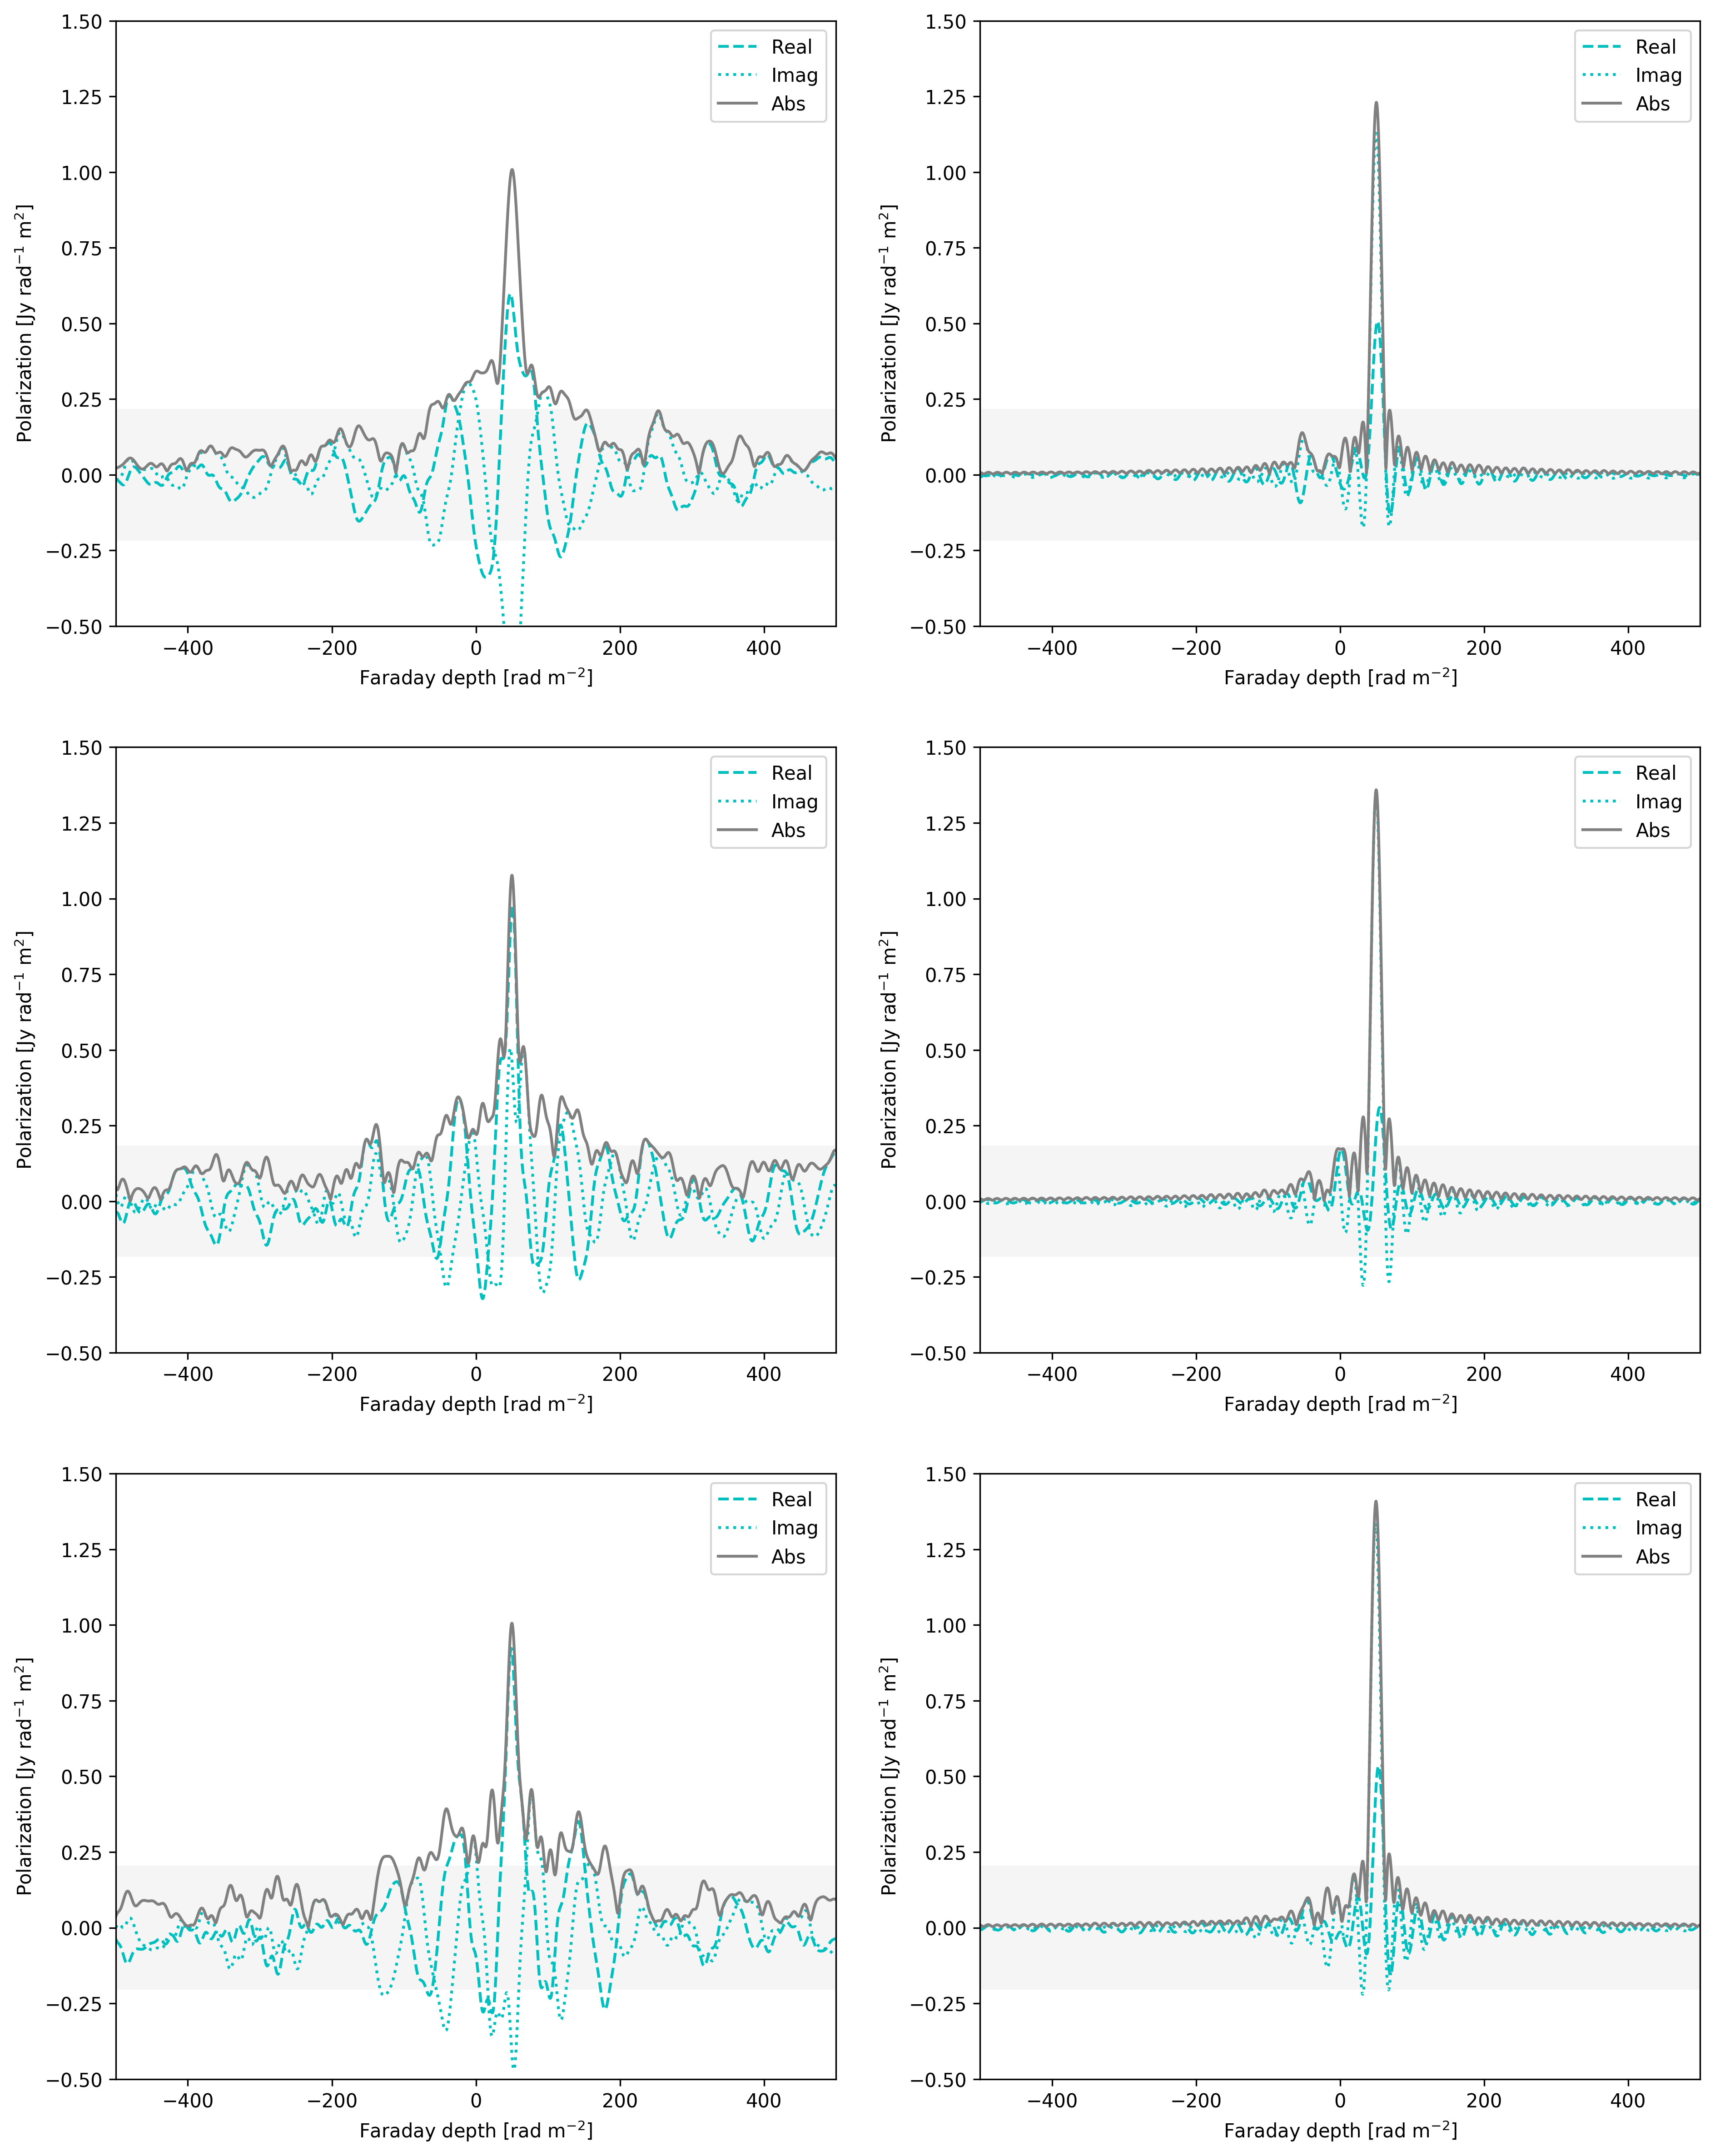

In [17]:
pl.subplot(321)
pl.fill_between([-500,500],[-sigma_fd20,-sigma_fd20],[sigma_fd20,sigma_fd20], facecolor='whitesmoke')
pl.plot(phi,np.real(fspec20),ls='--',c='c',label="Real")
pl.plot(phi,np.imag(fspec20),ls=':',c='c',label="Imag")
pl.plot(phi,np.abs(fspec20),ls='-',c='grey',label="Abs")
pl.xlim(-500,500)
pl.ylim(-0.5,1.5)
pl.ylabel(r"Polarization [Jy rad$^{-1}$ m$^2$]")
pl.xlabel(r"Faraday depth [rad m$^{-2}$]")
pl.legend()

pl.subplot(322)
pl.fill_between([-500,500],[-sigma_fd20,-sigma_fd20],[sigma_fd20,sigma_fd20], facecolor='whitesmoke')
pl.plot(phi,np.real(fspec20gp),ls='--',c='c',label="Real")
pl.plot(phi,np.imag(fspec20gp),ls=':',c='c',label="Imag")
pl.plot(phi,np.abs(fspec20gp),ls='-',c='grey',label="Abs")    
pl.xlim(-500,500)
pl.ylim(-0.5,1.5)
pl.ylabel(r"Polarization [Jy rad$^{-1}$ m$^2$]")
pl.xlabel(r"Faraday depth [rad m$^{-2}$]")
pl.legend()

pl.subplot(323)
pl.fill_between([-500,500],[-sigma_fd30,-sigma_fd30],[sigma_fd30,sigma_fd30], facecolor='whitesmoke')
pl.plot(phi,np.real(fspec30),ls='--',c='c',label="Real")
pl.plot(phi,np.imag(fspec30),ls=':',c='c',label="Imag")
pl.plot(phi,np.abs(fspec30),ls='-',c='grey',label="Abs")
pl.xlim(-500,500)
pl.ylim(-0.5,1.5)
pl.ylabel(r"Polarization [Jy rad$^{-1}$ m$^2$]")
pl.xlabel(r"Faraday depth [rad m$^{-2}$]")
pl.legend()

pl.subplot(324)
pl.fill_between([-500,500],[-sigma_fd30,-sigma_fd30],[sigma_fd30,sigma_fd30], facecolor='whitesmoke')
pl.plot(phi,np.real(fspec30gp),ls='--',c='c',label="Real")
pl.plot(phi,np.imag(fspec30gp),ls=':',c='c',label="Imag")
pl.plot(phi,np.abs(fspec30gp),ls='-',c='grey',label="Abs")    
pl.xlim(-500,500)
pl.ylim(-0.5,1.5)
pl.ylabel(r"Polarization [Jy rad$^{-1}$ m$^2$]")
pl.xlabel(r"Faraday depth [rad m$^{-2}$]")
pl.legend()

pl.subplot(325)
pl.fill_between([-500,500],[-sigma_fd40,-sigma_fd40],[sigma_fd40,sigma_fd40], facecolor='whitesmoke')
pl.plot(phi,np.real(fspec40),ls='--',c='c',label="Real")
pl.plot(phi,np.imag(fspec40),ls=':',c='c',label="Imag")
pl.plot(phi,np.abs(fspec40),ls='-',c='grey',label="Abs")
pl.xlim(-500,500)
pl.ylim(-0.5,1.5)
pl.ylabel(r"Polarization [Jy rad$^{-1}$ m$^2$]")
pl.xlabel(r"Faraday depth [rad m$^{-2}$]")
pl.legend()

pl.subplot(326)
pl.fill_between([-500,500],[-sigma_fd40,-sigma_fd40],[sigma_fd40,sigma_fd40], facecolor='whitesmoke')
pl.plot(phi,np.real(fspec40gp),ls='--',c='c',label="Real")
pl.plot(phi,np.imag(fspec40gp),ls=':',c='c',label="Imag")
pl.plot(phi,np.abs(fspec40gp),ls='-',c='grey',label="Abs")    
pl.xlim(-500,500)
pl.ylim(-0.5,1.5)
pl.ylabel(r"Polarization [Jy rad$^{-1}$ m$^2$]")
pl.xlabel(r"Faraday depth [rad m$^{-2}$]")
pl.legend()

pl.show()